Assignment 07 — Deep Learning for NLP (Colab Notebook)
Task: Classify Twitter sentiment (Apple/Google) into 4 classes: positive, negative, neutral, no_idea using LSTM (or SimpleRNN).

In [41]:
import os, sys, re, json, pickle, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print('Python:', sys.version)
print('TensorFlow:', tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0


# Load *Dataset*

In [42]:
df = None
path="/content/judge-1377884607_tweet_product_company.csv"
if path is not None:
    df = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv", encoding='latin1')
    print('Rows:', len(df))
    display(df.head(3))

Rows: 9093


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


# Minimal Exploratory Data Analysis (EDA)


In [43]:
assert df is not None, "Dataset not loaded. Please set `csv_path` above and re-run."

print('\nColumns:', df.columns.tolist())
target_col = 'is_there_an_emotion_directed_at_a_brand_or_product'
if target_col not in df.columns:
    raise ValueError("Expected a target column named '%s'. Found: %s" % (target_col, df.columns.tolist()))


print('\nClass distribution:')
print(df[target_col].value_counts(dropna=False))

# Keep only the text & target columns
text_col_candidates = ['tweet_text', 'text', 'content', 'message']
text_col = None
for c in text_col_candidates:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise ValueError("Couldn't find a text column. Expected one of: %s" % text_col_candidates)

work_df = df[[text_col, target_col]].copy().rename(columns={text_col: 'text', target_col: 'emotion'})
print('\nWorking columns:', work_df.columns.tolist())
work_df = work_df.dropna(subset=['text', 'emotion'])
work_df = work_df[work_df['text'].astype(str).str.strip().ne('')]
print('After cleaning empties -> Rows:', len(work_df))
display(work_df.sample(min(5, len(work_df))))


Columns: ['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']

Class distribution:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Working columns: ['text', 'emotion']
After cleaning empties -> Rows: 9092


,text,emotion
7169,Google Close to Launching New Social Network -...,No emotion toward brand or product
2089,iPhone charging at #SXSW {link},No emotion toward brand or product
2303,"The walk by Lady Bird Lake was lovely, but Goo...",Negative emotion
928,ÛÏ@mention Not a rumor: Apple doing popup sto...,Positive emotion
5895,RT @mention Google to Launch Major New Social ...,No emotion toward brand or product


In [44]:
def clean_text(s):
    s = str(s)
    s = re.sub(r'http\S+|www\S+', ' ', s)      # URLs
    s = re.sub(r'@[A-Za-z0-9_]+', ' ', s)       # @
    s = re.sub(r'#[A-Za-z0-9_]+', ' ', s)      # #
    s = re.sub(r'[^A-Za-z\s]', ' ', s)          # keep letters & spaces
    s = re.sub(r'\s+', ' ', s).strip()          # squeeze spaces
    return s.lower()

work_df['clean_text'] = work_df['text'].apply(clean_text)

# Encode labels
le = LabelEncoder()
work_df['label'] = le.fit_transform(work_df['emotion'])

label_map = {int(i): c for i, c in enumerate(le.classes_)}
print('Label mapping:', label_map)

print('\nSample cleaned:')
display(work_df[['text', 'clean_text', 'emotion']].head(5))


Label mapping: {0: "I can't tell", 1: 'Negative emotion', 2: 'No emotion toward brand or product', 3: 'Positive emotion'}

Sample cleaned:


,text,clean_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,i have a g iphone after hrs tweeting at it was...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you ll...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for also they should sale them do...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,i hope this year s festival isn t as crashy as...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff on fri marissa mayer google tim o ...,Positive emotion


# Tokenize & Pad Sequences

In [45]:
MAX_WORDS = 20000   # vocabulary size
MAX_LEN   = 60      # max tokens per tweet

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(work_df['clean_text'].tolist())

X = tokenizer.texts_to_sequences(work_df['clean_text'].tolist())
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')
y = work_df['label'].values

print('X shape:', X.shape, '| y shape:', y.shape)

X shape: (9092, 60) | y shape: (9092,)


# Train / Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train:', X_train.shape, ' Test:', X_test.shape)


Train: (7273, 60)  Test: (1819, 60)


# Build the Model (LSTM)

In [47]:
EMBED_DIM = 64
LSTM_UNITS = 64
DROPOUT = 0.3
NUM_CLASSES = len(np.unique(y))

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
    # SimpleRNN(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),  # <-- Alternative
    Bidirectional(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(DROPOUT),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the Model

Epoch 1/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5649 - loss: 1.0548

103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.5650 - loss: 1.0540 - val_accuracy: 0.6113 - val_loss: 0.8547
Epoch 2/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6317 - loss: 0.8589

103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.6319 - loss: 0.8587 - val_accuracy: 0.6552 - val_loss: 0.8065
Epoch 3/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7193 - loss: 0.7056

103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step - accuracy: 0.7195 - loss: 0.7054 - val_accuracy: 0.6621 - val_loss: 0.8260
Epoch 4/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.7877 - loss: 0.5726 - val_accuracy: 0.6484 - val_loss: 0.8950
Epoch 5/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.8258 - loss: 0.4922 - val_accuracy: 0.6525 - val_loss: 0.9584
Epoch 6/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8524 - loss: 0.4115

103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.8524 - loss: 0.4115 - val_accuracy: 0.6662 - val_loss: 1.0049
Epoch 7/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.8657 - loss: 0.3699 - val_accuracy: 0.6250 - val_loss: 1.1259
Epoch 8/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.8857 - loss: 0.3243 - val_accuracy: 0.6346 - val_loss: 1.1999
Epoch 9/12
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.8921 - loss: 0.3079 - val_accuracy: 0.6387 - val_loss: 1.2521


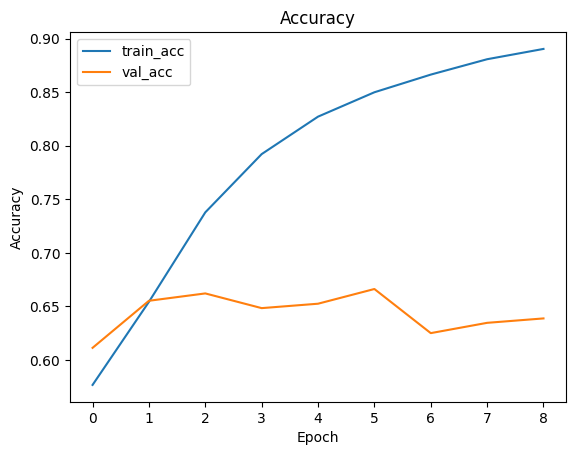

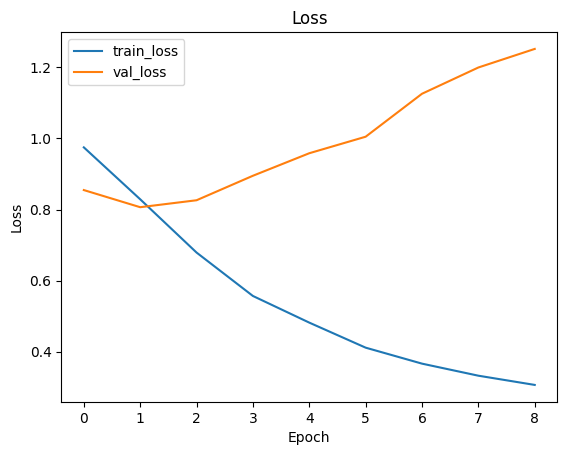

In [37]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=0)
]

history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()

# Evaluate on Test Set

Test Accuracy: 0.6542

Classification Report:
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.43      0.35      0.39       114
No emotion toward brand or product       0.72      0.77      0.74      1078
                  Positive emotion       0.57      0.54      0.56       596

                          accuracy                           0.65      1819
                         macro avg       0.43      0.42      0.42      1819
                      weighted avg       0.64      0.65      0.64      1819



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


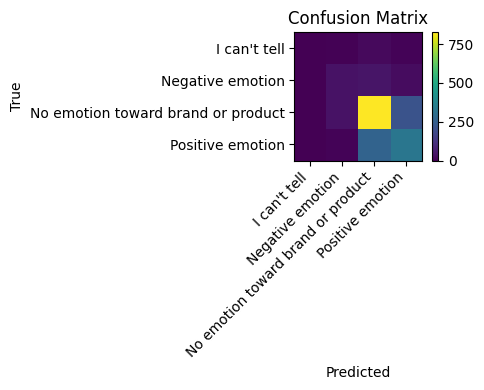

In [38]:

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = [label_map[i] for i in range(len(label_map))]
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha='right')
plt.yticks(tick_marks, target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


# Inference on New Tweets


In [39]:
def predict_sentiment(texts):
    clean = [clean_text(t) for t in texts]
    seqs = tokenizer.texts_to_sequences(clean)
    pads = pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')
    probs = model.predict(pads, verbose=0)
    idxs  = np.argmax(probs, axis=1)
    labels = [label_map[int(i)] for i in idxs]
    return labels, probs

samples = [
    "I love my new iPhone, it's awesome!",
    "The latest update ruined my Pixel battery life.",
    "Not sure what to feel about this Google feature.",
    "Ok ok, nothing special about this phone."
]
labels, probs = predict_sentiment(samples)
for s, l in zip(samples, labels):
    print(f'{l:>8} | {s}')


Positive emotion | I love my new iPhone, it's awesome!
Positive emotion | The latest update ruined my Pixel battery life.
No emotion toward brand or product | Not sure what to feel about this Google feature.
Positive emotion | Ok ok, nothing special about this phone.


Save Artifacts (Tokenizer, Label Encoder, Model)

In [40]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save trained model
model.save('lstm_tweet_sentiment.h5')
print('Saved: tokenizer.json, label_encoder.pkl, lstm_tweet_sentiment.h5')


Saved: tokenizer.json, label_encoder.pkl, lstm_tweet_sentiment.h5
